<a href="https://colab.research.google.com/github/pyagoubi/Stuff/blob/main/stockpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install bt

In [23]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader
#import bt as bt
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset

In [101]:
tech_daily_raw = pd.read_csv('/content/drive/MyDrive/stock predict/technical/1D_technical.csv')
#features = ['open', 'high', 'low', 'close', 'rsi', 'adx', 'cci', 'ema', 'stoch', 'trend_macd', 'momentum_stoch', 'volatility_atr']
features = ['close','rsi', 'adx', 'cci', 'ema', 'stoch']
tech_daily = tech_daily_raw[features].copy()

# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] notebook with \'{}\' computation enabled'.format(str(now), str(device)))





[LOG 20230517-05:04:15] notebook with 'cuda' computation enabled


In [102]:
tech_daily['return'] = np.log(tech_daily['close']) - np.log(tech_daily['close'].shift(1))

In [103]:
features = features + ['return']
#features = ['return']

tech_daily = tech_daily[features]

In [104]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
tech_daily_scaled = pd.DataFrame(scaler.fit_transform(tech_daily), columns = features)

In [105]:
split_fraction = 0.8
split_row = int(tech_daily.shape[0] * split_fraction)
train_stock_data_return = tech_daily_scaled.iloc[:split_row]
valid_stock_data_return = tech_daily_scaled.iloc[split_row:]

In [106]:
train_stock_data_return = train_stock_data_return[1:]

In [107]:
time_steps = 4 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length

In [108]:
import numpy as np
import torch

def create_sequences(df, seq_length):
    df = df.values  # Convert DataFrame to numpy array
    
    n = df.shape[0]
    xs = np.zeros((n - seq_length, seq_length, df.shape[1]))
    ys = np.zeros((n - seq_length, 1))
    
    for i in range(n - seq_length):
        xs[i] = df[i:(i+seq_length)]
        ys[i] = df[i+seq_length, -1]  # predict the 'return' column one step ahead
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(xs)
    y = torch.from_numpy(ys)
    
    return X, y

In [109]:
train, train_target = create_sequences(train_stock_data_return, sequence_length)
valid, valid_target = create_sequences(valid_stock_data_return, sequence_length)

In [110]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [124]:
import torch
import torch.nn as nn

class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, 5, num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(5, 1)
        #self.fc3 = nn.Linear(10, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc1(out[:, -1, :])
        #out = self.fc2(out)
        #out = self.fc3(out)
        
        return out

In [118]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

Epoch 1/30, Train Loss: 1.0276, Validation Loss: 0.7745
Epoch 2/30, Train Loss: 1.0259, Validation Loss: 0.7742
Epoch 3/30, Train Loss: 1.0221, Validation Loss: 0.7747
Epoch 4/30, Train Loss: 1.0252, Validation Loss: 0.7748
Epoch 5/30, Train Loss: 1.0248, Validation Loss: 0.7753
Epoch 6/30, Train Loss: 1.0224, Validation Loss: 0.7752
Epoch 7/30, Train Loss: 1.0210, Validation Loss: 0.7763
Epoch 8/30, Train Loss: 1.0240, Validation Loss: 0.7765
Epoch 9/30, Train Loss: 1.0211, Validation Loss: 0.7769
Epoch 10/30, Train Loss: 1.0260, Validation Loss: 0.7761
Epoch 11/30, Train Loss: 1.0207, Validation Loss: 0.7756
Epoch 12/30, Train Loss: 1.0214, Validation Loss: 0.7757
Epoch 13/30, Train Loss: 1.0227, Validation Loss: 0.7754
Epoch 14/30, Train Loss: 1.0197, Validation Loss: 0.7764
Epoch 15/30, Train Loss: 1.0214, Validation Loss: 0.7760
Epoch 16/30, Train Loss: 1.0213, Validation Loss: 0.7766
Epoch 17/30, Train Loss: 1.0234, Validation Loss: 0.7773
Epoch 18/30, Train Loss: 1.0196, Validat

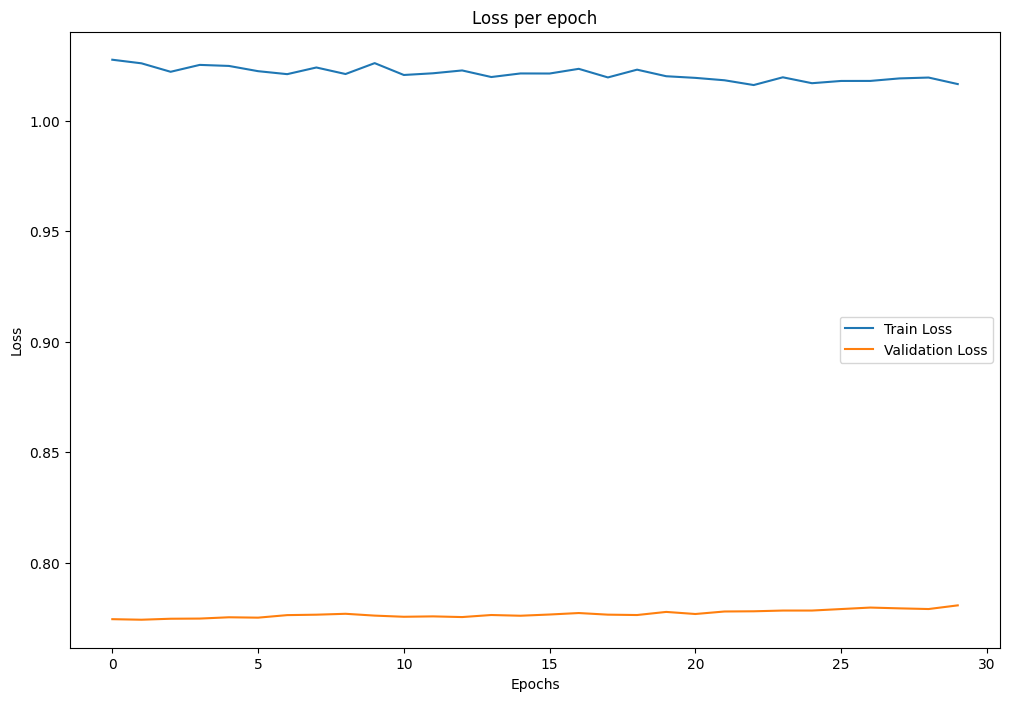

MultivariateLSTM(
  (lstm): LSTM(7, 5, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [125]:
from torch.utils.data import DataLoader
import copy

def train_model(model, train, train_target, valid, valid_target, learning_rate, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    #criterion = nn.MSELoss()
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = SequenceDataset(train, train_target)
    val_dataset = SequenceDataset(valid, valid_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_epoch_losses = []
        for sequences, targets in train_loader:
            sequences = sequences.float().to(device)  # Convert to float
            targets = targets.float().to(device)  # Convert to float


            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_losses.append(loss.item())

        model.eval()
        val_epoch_losses = []
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.float().to(device)  # Convert to float
                targets = targets.float().to(device)  # Convert to float


                outputs = model(sequences)
                loss = criterion(outputs, targets)
                val_epoch_losses.append(loss.item())

        
        train_loss = np.mean(train_epoch_losses)
        val_loss = np.mean(val_epoch_losses)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}')


        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')  # Save the model


    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot the train loss and validation loss per epoch
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

# Use the function:
num_features = train.shape[-1]  # X is your input data
model = MultivariateLSTM(input_size=num_features, hidden_size=5, num_layers=2, output_size=1)
train_model(model, train, train_target, valid, valid_target, learning_rate=0.001, num_epochs=30)


In [10]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, sequence_length):
    df = df.copy()  # Create a copy of the DataFrame

    # Select the columns to be scaled
    columns_to_scale = df.columns

    # Scale the selected columns using StandardScaler
    scaler = MinMaxScaler()
    df.loc[:, columns_to_scale] = scaler.fit_transform(df.loc[:, columns_to_scale])

    # Shift the 'return' column by one step
    df['return_shifted'] = df['return'].shift(-1)

    # Drop the last row since it will have NaN values
    df = df[:-1]

    df=df[1:]

    # Initialize empty lists for input sequences and target values
    input_sequences = []
    targets = []

    # Generate input sequences and corresponding targets
    for i in range(len(df) - sequence_length):
        seq = df.iloc[i : i + sequence_length].values  # Get the sequence of length sequence_length
        target = df.iloc[i + sequence_length]['return_shifted']  # Get the target value for the next time step

        input_sequences.append(seq)
        targets.append(target)

    # Convert input sequences and targets to PyTorch tensors
    input_sequences = torch.Tensor(input_sequences)
    targets = torch.Tensor(targets)

    return input_sequences, targets



import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, input_sequences, targets):
        self.input_sequences = input_sequences
        self.targets = targets

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        x = self.input_sequences[idx]
        y = self.targets[idx]
        return x, y











In [11]:
train_stock = preprocess_data(train_stock_data_return, sequence_length) 
valid_stock = preprocess_data(valid_stock_data_return, sequence_length) 

<ipython-input-10-f8b6399d43a7>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_sequences = torch.Tensor(input_sequences)


In [93]:
train_dataset = MyDataset(train_stock_data_return)
valid_dataset = MyDataset(valid_stock_data_return)

In [ ]:
import torch
import torch.nn as nn

class MyLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)  # First linear layer
        self.fc2 = nn.Linear(64, output_size)  # Second linear layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM layer
        out = self.fc1(out[:, -1, :])  # Extract the last time step output and pass it through the first linear layer
        out = self.fc2(out)  # Second linear layer
        return out

# Example usage
input_size = 13  # Number of input features (columns except 'return')
hidden_size = 128  # Number of hidden units in each LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output units (prediction for 'return')

model = MyLSTMModel(input_size, hidden_size, num_layers, output_size)

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, train_dataset, val_dataset, num_epochs, batch_size, learning_rate, device):
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    best_val_loss = float('inf')  # Initialize best validation loss

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()  # Set model to train mode
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_dataset)

        # Display statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    print("Training completed!")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have train_dataset and val_dataset objects already defined

# Initialize the model
model = MyLSTMModel(input_size, hidden_size, num_layers, output_size)
model.to(device)

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Train the model
train(model, train_dataset, valid_dataset, num_epochs, batch_size, learning_rate, device)


ValueError: ignored